In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from pprint import pprint
import pickle
import time
import datetime

In [2]:
from qiskit.circuit import Parameter, QuantumCircuit
from qiskit.compiler import transpile
from qiskit.transpiler.passes import RemoveBarriers
import qiskit.quantum_info as qi

In [3]:
from kagome_trotter.circuits_1d_path import gate_path_conventional, gate_path_proposed
from kagome_trotter.simulator_dm import compute_distance_trace_unitary_mod_phase
from kagome_trotter.hamiltonian import make_H_Heisenberg_path

In [4]:
num_qubits = 7
time_evolution = 2 * np.pi
num_steps_list = list(range(10,500,50))
print("trotter step list: ", num_steps_list)

trotter step list:  [10, 60, 110, 160, 210, 260, 310, 360, 410, 460]


In [5]:
H_Heisenberg = make_H_Heisenberg_path(num_qubits=num_qubits) ### create Heisenberg Hamiltonian in a dictionary format
H = qi.SparsePauliOp.from_list(list(H_Heisenberg.items()))
print(H)
dm_H = H.to_matrix() ### same, np.allclose(dm_H, matrix_Heisenberg)
U = sp.linalg.expm(-1j * dm_H * time_evolution) ###! same, np.allclose(U, U_Heisenberg)

SparsePauliOp(['XXIIIII', 'YYIIIII', 'ZZIIIII', 'IXXIIII', 'IYYIIII', 'IZZIIII', 'IIXXIII', 'IIYYIII', 'IIZZIII', 'IIIXXII', 'IIIYYII', 'IIIZZII', 'IIIIXXI', 'IIIIYYI', 'IIIIZZI', 'IIIIIXX', 'IIIIIYY', 'IIIIIZZ'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j])


In [6]:
dt = Parameter('dt')

fidelities_conventional = []
fidelities_proposed = []

distances_trace_conventional = []
distances_trace_proposed = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()

    matrix_path_qiskit = \
        qi.Operator(gate_path_conventional(num_qubits=num_qubits,
                                        num_steps=num_steps,
                                        dt=time_evolution / num_steps,
                                        type_block="3cnot",
                                        to_instruction=False,
                                        add_barrier=False,
                                       )
                   )# .data

    matrix_path_proposed = \
        qi.Operator(gate_path_proposed(num_qubits=num_qubits,
                                        num_steps=num_steps // 2, ###!
                                        dt=2 * time_evolution / num_steps, ###!
                                        type_H_eff="new",
                                        to_instruction=False,
                                        add_barrier=False,
                                       )
                   )# .data


    # operator_Hiesenberg = qi.Operator(U_Heisenberg.data)

    fidelities_conventional.append(qi.process_fidelity(matrix_path_qiskit, qi.Operator(U)))
    fidelities_proposed.append(qi.process_fidelity(matrix_path_proposed, qi.Operator(U)))

    distances_trace_conventional.append(compute_distance_trace_unitary_mod_phase(matrix_path_qiskit.data, qi.Operator(U).data))
    distances_trace_proposed.append(compute_distance_trace_unitary_mod_phase(matrix_path_proposed.data, qi.Operator(U).data))
    
    t2 = time.perf_counter()
    print('process fidelity between conventional and U_Heisenberg = {:.4f}'.format(fidelities_conventional[-1]))
    print('process fidelity between proposed and U_Heisenberg = {:.4f}'.format(fidelities_proposed[-1]))
    print()
    print('trace norm between conventional and U_Heisenberg = {:.4f}'.format(distances_trace_conventional[-1]))
    print('trace norm between proposed and U_Heisenberg = {:.4f}'.format(distances_trace_proposed[-1]))
    print("time:", t2 - t1)
    print()

trotter steps:  10
process fidelity between conventional and U_Heisenberg = 0.0064
process fidelity between proposed and U_Heisenberg = 0.0015

trace norm between conventional and U_Heisenberg = 77.0800
trace norm between proposed and U_Heisenberg = 78.6122
time: 0.13018429116345942

trotter steps:  60
process fidelity between conventional and U_Heisenberg = 0.9711
process fidelity between proposed and U_Heisenberg = 0.8122

trace norm between conventional and U_Heisenberg = 8.4611
trace norm between proposed and U_Heisenberg = 23.1633
time: 0.7255355839151889

trotter steps:  110
process fidelity between conventional and U_Heisenberg = 0.9940
process fidelity between proposed and U_Heisenberg = 0.9702

trace norm between conventional and U_Heisenberg = 3.8297
trace norm between proposed and U_Heisenberg = 9.0165
time: 1.2756553748622537

trotter steps:  160
process fidelity between conventional and U_Heisenberg = 0.9974
process fidelity between proposed and U_Heisenberg = 0.9891

trac

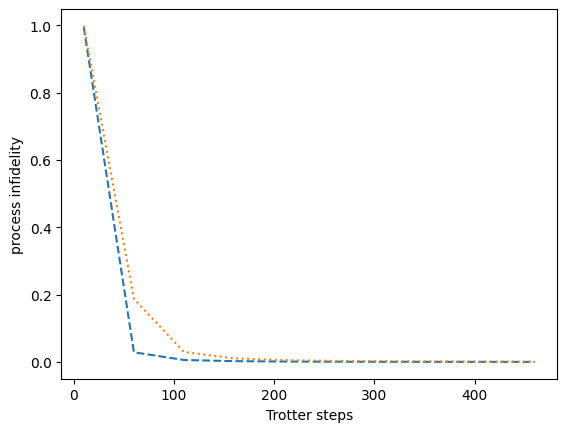

In [7]:
plt.plot(num_steps_list, 1 - np.array(fidelities_conventional), linestyle="dashed")
plt.plot(num_steps_list, 1 - np.array(fidelities_proposed), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
# plt.yscale("log")
# plt.ylim(bottom=0,top=1)
plt.show()

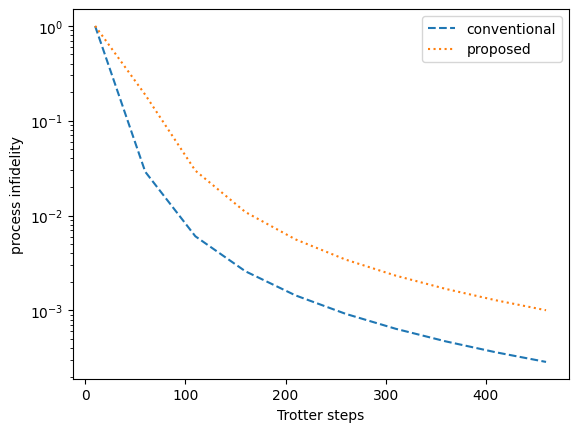

In [8]:
plt.clf()
p3, = plt.plot(num_steps_list, 1 - np.array(fidelities_conventional), linestyle="dashed")
p4, = plt.plot(num_steps_list, 1 - np.array(fidelities_proposed), linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("process infidelity")
plt.yscale("log")
plt.legend([p3,p4],["conventional","proposed"])
plt.show()

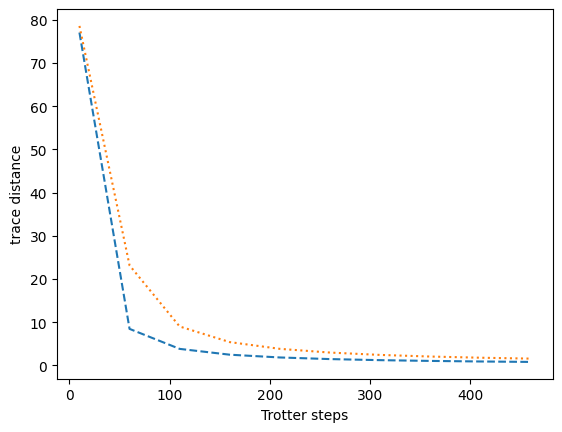

In [9]:
plt.plot(num_steps_list, distances_trace_conventional, linestyle="dashed")
plt.plot(num_steps_list, distances_trace_proposed, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.show()

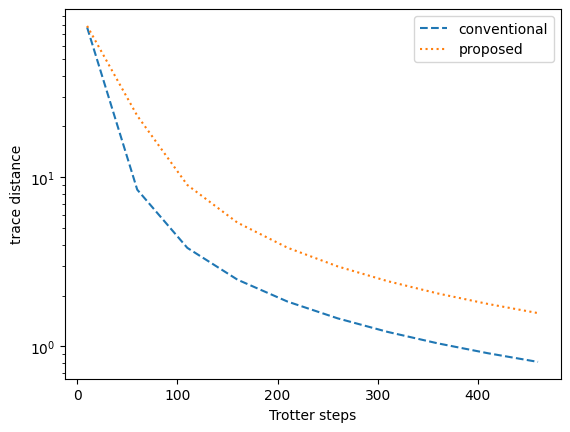

In [10]:
p3, = plt.plot(num_steps_list, distances_trace_conventional, linestyle="dashed")
p4, = plt.plot(num_steps_list, distances_trace_proposed, linestyle="dotted")
plt.xlabel("Trotter steps")
plt.ylabel("trace distance")
plt.yscale("log")
plt.legend([p3,p4],["conventional","proposed"])
plt.show()

In [11]:
dt = Parameter('dt')

nums_cnot_conventional = []
nums_cnot_proposed = []

for num_steps in num_steps_list:
    
    print("trotter steps: ", num_steps)
    t1 = time.perf_counter()

    qc_conventional = QuantumCircuit(num_qubits)
    qc_conventional.compose(gate_path_conventional(num_qubits=num_qubits,
                                                  num_steps=num_steps,
                                                  dt=time_evolution / num_steps,
                                                  type_block="3cnot",
                                                  to_instruction=False,
                                                  add_barrier=False,
                                                 ),
                           qubits=list(range(num_qubits)),
                           inplace=True,)
    # qc_conventional = qc_conventional.assign_parameters({dt: time_evolution / num_steps})
    qc_conventional_t3 = transpile(RemoveBarriers()(qc_conventional), 
                               optimization_level=3, 
                               basis_gates=["sx", "cx", "rz"])
    nums_cnot_conventional.append(qc_conventional_t3.count_ops().get("cx"))
    
    qc_proposed = QuantumCircuit(num_qubits)
    qc_proposed.compose(gate_path_proposed(num_qubits=num_qubits,
                                          num_steps=num_steps // 2, ###!
                                          dt=2 * time_evolution / num_steps, ###!
                                          type_H_eff="new",
                                          to_instruction=False,
                                          add_barrier=False,
                                        ),
                       qubits=list(range(num_qubits)),
                       inplace=True,)
    # qc_proposed = qc_proposed.assign_parameters({dt: time_evolution / num_steps})
    qc_proposed_t3 = transpile(RemoveBarriers()(qc_proposed), 
                               optimization_level=3, 
                               basis_gates=["sx", "cx", "rz"])
    nums_cnot_proposed.append(qc_proposed_t3.count_ops().get("cx"))
    
    t2 = time.perf_counter()
    print("number of CNOT gates in conventional:", nums_cnot_conventional[-1])
    print("number of CNOT gates in proposed:", nums_cnot_proposed[-1])
    print("time:", t2 - t1)
    print()

trotter steps:  10
number of CNOT gates in conventional: 180
number of CNOT gates in proposed: 112
time: 0.7822573750745505

trotter steps:  60
number of CNOT gates in conventional: 1080
number of CNOT gates in proposed: 662
time: 0.05600616685114801

trotter steps:  110
number of CNOT gates in conventional: 1980
number of CNOT gates in proposed: 1212
time: 0.09585145791061223

trotter steps:  160
number of CNOT gates in conventional: 2880
number of CNOT gates in proposed: 1762
time: 0.14918329194188118

trotter steps:  210
number of CNOT gates in conventional: 3780
number of CNOT gates in proposed: 2312
time: 0.17489104205742478

trotter steps:  260
number of CNOT gates in conventional: 4680
number of CNOT gates in proposed: 2862
time: 0.21925824997015297

trotter steps:  310
number of CNOT gates in conventional: 5580
number of CNOT gates in proposed: 3412
time: 0.26171095785684884

trotter steps:  360
number of CNOT gates in conventional: 6480
number of CNOT gates in proposed: 3962
t

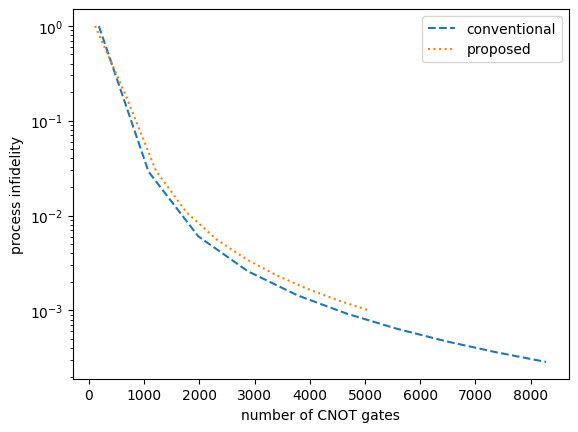

In [12]:
plt.clf()
p3, = plt.plot(nums_cnot_conventional, 1 - np.array(fidelities_conventional), linestyle="dashed")
p4, = plt.plot(nums_cnot_proposed, 1 - np.array(fidelities_proposed), linestyle="dotted")
plt.xlabel("number of CNOT gates")
plt.ylabel("process infidelity")
plt.yscale("log")
plt.legend([p3,p4],["conventional","proposed"])
plt.show()